In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/youtube-dislikes-info/train.csv
/kaggle/input/youtube-dislikes-info/test.csv


In [2]:
# Load the train set
dislikes = pd.read_csv("/kaggle/input/youtube-dislikes-info/train.csv")

In [3]:
# Load the test set
test = pd.read_csv("/kaggle/input/youtube-dislikes-info/test.csv")

# ***INSPECT DATA***

In [4]:
dislikes.head()

,upload_date,uploader_sub_count,view_count,like_count,dislike_count,has_subtitles,is_ads_enabled,is_comments_enabled,is_age_limit,is_live_content,description,title
0,20160205,789,778,12,0,False,False,False,False,False,Provided to YouTube by Hungaroton\n\nEltávozot...,Eltávozott nap
1,20121001,221,32,1,0,False,False,True,False,False,"y0 guys, one of my shots from my hitlists, but...",Hitlist Fail:/ #B2R
2,20210601,112,12,2,0,True,False,True,False,False,https://store.playstation.com/#!/tid=...,Call of Duty® warzone amp63
3,20210523,97,45,16,0,False,False,True,False,False,#حالات _واتساب _دينية,حالات واتساب اجمل صوت (سلمت قلبي ❤) تصميمي.
4,20201124,469,16,6,0,True,False,True,False,False,"Since I reviewed Fight Club earlier in 2020, I...",Fight Club (1999) Spoiler Review


In [5]:
dislikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671277 entries, 0 to 671276
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   upload_date          671277 non-null  object
 1   uploader_sub_count   671277 non-null  int64 
 2   view_count           671277 non-null  int64 
 3   like_count           671277 non-null  int64 
 4   dislike_count        671277 non-null  int64 
 5   has_subtitles        671277 non-null  bool  
 6   is_ads_enabled       671277 non-null  bool  
 7   is_comments_enabled  671277 non-null  bool  
 8   is_age_limit         671277 non-null  bool  
 9   is_live_content      671277 non-null  bool  
 10  description          503648 non-null  object
 11  title                671270 non-null  object
dtypes: bool(5), int64(4), object(3)
memory usage: 39.1+ MB


# ***EDA***

We have two-thirds of a million YouTube videos as training data, and one-third as testing data. Excluding our **dependent** variable, we have 3 quantitative features and 8 qualitative features for a total of **11** attributes. Additionally, there are a lot of **missing values** on the description variable. If we were to perform sentiment analysis on that feature, we may need to drop a large amount of observations. 
<br><br>

First, let's conduct an analysis on our quantatitative features. How do any of these features affect our response, the dislike count? 

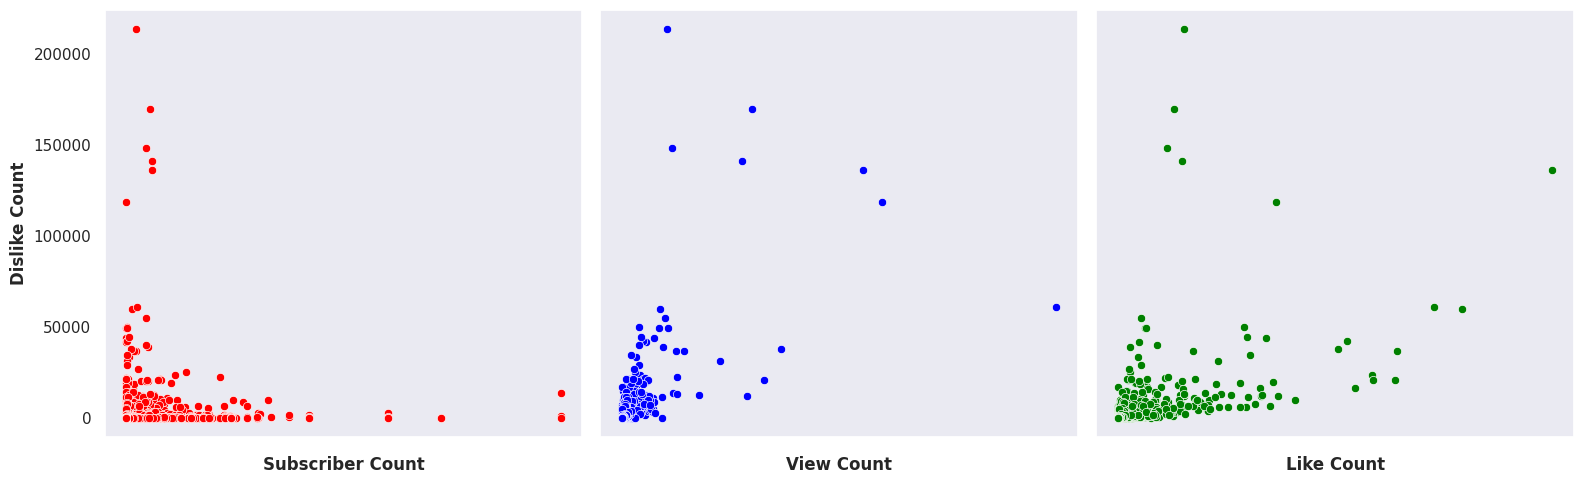

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set(style='dark')
plt.figure(figsize=(16, 5))  # Adjust the figure size to fit all subplots

# Subscriber counts
plt.subplot(1, 3, 1)  
sns.scatterplot(data=dislikes, x="uploader_sub_count", y="dislike_count", color='red')
plt.gca().set_xticklabels([])
plt.xlabel("Subscriber Count", fontweight='bold')
plt.ylabel("Dislike Count", fontweight='bold')

# View counts
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.scatterplot(data=dislikes, x="view_count", y="dislike_count", color='blue')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlabel("View Count", fontweight='bold')
plt.ylabel("")

# Like counts
plt.subplot(1, 3, 3)  
sns.scatterplot(data=dislikes, x="like_count", y="dislike_count", color='green')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlabel("Like Count", fontweight='bold')
plt.ylabel("")

plt.tight_layout() 
# plt.suptitle("Quantitative Features vs. Dislike Counts", fontsize=20, fontweight='bold')
plt.show()

View count is roughly okay; the linearity assumption has been met. However, it seems that the subscriber count and the like count may need some extra work. While there appears to be a relationship between these variables and the number of dislikes, this relationship is **not linear**, which suggests the need for **transformations**. 

Let's inspect this relationship further with a **heatmap**.

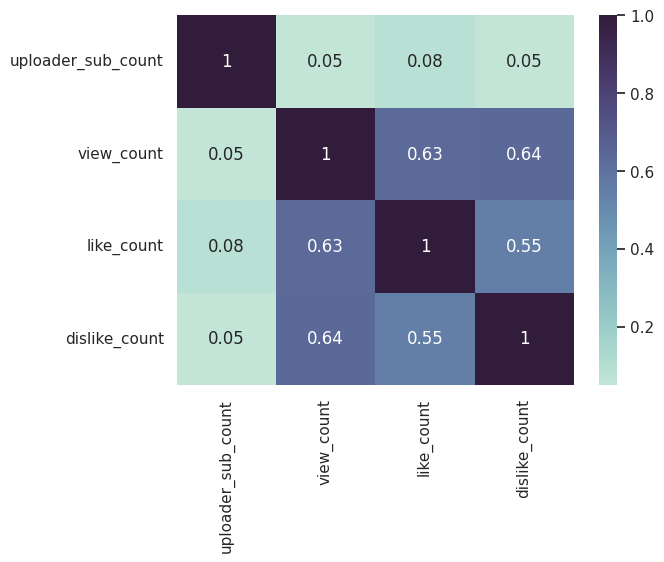

In [7]:
numeric = round(dislikes.select_dtypes(include='int64').corr(), 2)
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# Create a heatmap showing correlations between quantitative features
sns.heatmap(numeric, cmap=palette, annot=True, annot_kws={"size": 12})
plt.show()

In [8]:
numeric.corr()

,uploader_sub_count,view_count,like_count,dislike_count
uploader_sub_count,1.000000,-0.905463,-0.839371,-0.877474
view_count,-0.905463,1.000000,0.684587,0.714166
like_count,-0.839371,0.684587,1.000000,0.543808
dislike_count,-0.877474,0.714166,0.543808,1.000000


The heatmap seems to support my initial observation. Without any engineering, the uploader sub count **does not** seem to be an accurate predictor for the dislike count. However, the like count does show positive results, so I'll leave it alone. This heatmap also provides insight into the variables' relationships with one another. In particular, the **view count** and the **like count** seem closely related; we may need to watch out for **multicollinearity**.

# ***FEATURE ENGINEERING***

At the moment, we can't really do much with the upload date feature. It is not quantitative, so we can't fit it into our model. There is a simple solution to this though—why don't we measure a video's age in days? This should give us the numerical feature we want. 

In [9]:
# Convert to pandas datetime to access additional attributes
dislikes['upload_date'] = pd.to_datetime(dislikes['upload_date'], errors='coerce')
# Obtain the number of days
dislikes['age'] = (pd.Timestamp.today() - dislikes["upload_date"]).dt.days

In [10]:
dislikes.head()

,upload_date,uploader_sub_count,view_count,like_count,dislike_count,has_subtitles,is_ads_enabled,is_comments_enabled,is_age_limit,is_live_content,description,title,age
0,2016-02-05,789,778,12,0,False,False,False,False,False,Provided to YouTube by Hungaroton\n\nEltávozot...,Eltávozott nap,3103.0
1,2012-10-01,221,32,1,0,False,False,True,False,False,"y0 guys, one of my shots from my hitlists, but...",Hitlist Fail:/ #B2R,4325.0
2,2021-06-01,112,12,2,0,True,False,True,False,False,https://store.playstation.com/#!/tid=...,Call of Duty® warzone amp63,1160.0
3,2021-05-23,97,45,16,0,False,False,True,False,False,#حالات _واتساب _دينية,حالات واتساب اجمل صوت (سلمت قلبي ❤) تصميمي.,1169.0
4,2020-11-24,469,16,6,0,True,False,True,False,False,"Since I reviewed Fight Club earlier in 2020, I...",Fight Club (1999) Spoiler Review,1349.0


In [11]:
# Convert to pandas datetime to access additional attributes
test['upload_date'] = pd.to_datetime(test['upload_date'], errors='coerce')
# Obtain the number of days
test['age'] = (pd.Timestamp.today() - test["upload_date"]).dt.days

Now, let's bring back the  subscriber count scatterplot. As mentioned before, it can be shown that there exists a nonlinear relationship between the two variables. This suggests the need for transformations.

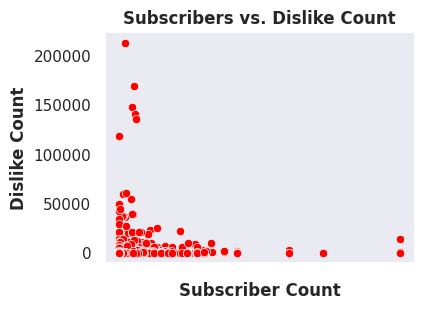

In [12]:
# Subscriber counts
plt.figure(figsize=(4, 3))
sns.scatterplot(data=dislikes, x="uploader_sub_count", y="dislike_count", color='red')
plt.gca().set_xticklabels([])
plt.xlabel("Subscriber Count", fontweight='bold')
plt.ylabel("Dislike Count", fontweight='bold')
plt.title("Subscribers vs. Dislike Count", fontweight='bold')

plt.show()

To capture this non-linear relationship, we can try a log transformation. This has the effect of linearizing the relationship to a degree, which is an important assumption for linear regression.

In [13]:
dislikes[dislikes['uploader_sub_count'] < 0] = 0 

# Reciprocate the sub count 
dislikes['uploader_sub_count_log'] = np.log1p(dislikes['uploader_sub_count'])

In [14]:
test[test['uploader_sub_count'] < 0] = 0 

# Reciprocate the sub count 
test['uploader_sub_count_log'] = np.log1p(test['uploader_sub_count'])

Because there are a lot of missing values specifically in the description and title variables, I've decided to **exclude** them from the full model. In their place, I've chosen to simply encode them by whether or not that feature is present in a video. Who knows—it might be possible that videos without a description get more dislikes than those with one. 

In [15]:
dislikes['has_description'] = dislikes['description'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [16]:
dislikes.head()

,upload_date,uploader_sub_count,view_count,like_count,dislike_count,has_subtitles,is_ads_enabled,is_comments_enabled,is_age_limit,is_live_content,description,title,age,uploader_sub_count_log,has_description
0,2016-02-05 00:00:00,789,778,12,0,False,False,False,False,False,Provided to YouTube by Hungaroton\n\nEltávozot...,Eltávozott nap,3103.0,6.672033,1
1,2012-10-01 00:00:00,221,32,1,0,False,False,True,False,False,"y0 guys, one of my shots from my hitlists, but...",Hitlist Fail:/ #B2R,4325.0,5.402677,1
2,2021-06-01 00:00:00,112,12,2,0,True,False,True,False,False,https://store.playstation.com/#!/tid=...,Call of Duty® warzone amp63,1160.0,4.727388,1
3,2021-05-23 00:00:00,97,45,16,0,False,False,True,False,False,#حالات _واتساب _دينية,حالات واتساب اجمل صوت (سلمت قلبي ❤) تصميمي.,1169.0,4.584967,1
4,2020-11-24 00:00:00,469,16,6,0,True,False,True,False,False,"Since I reviewed Fight Club earlier in 2020, I...",Fight Club (1999) Spoiler Review,1349.0,6.152733,1


In [17]:
test['has_description'] = test['description'].apply(lambda x: 0 if pd.isnull(x) else 1)

Now, we're ready to preprocess our data for fitting. 

# ***DATA PREPROCESSING***

Having experimented with several features, I believe that these four are ones that truly don't have much impact on our model. They will be removed to anticipate and eliminate some of the noise present with our current feature set. 

In [18]:
features_to_drop = ['upload_date', 'title', 'description', 'uploader_sub_count']

In [19]:
dislikes = dislikes.drop(dislikes[features_to_drop], axis=1)
dislikes = dislikes.dropna()

In [20]:
test = test.drop(test[features_to_drop], axis=1)
test = test.dropna()

Now, let's one-hot encode our qualitative features prior to fitting our model. 

In [21]:
cat = ['has_subtitles', 'is_comments_enabled', 'is_ads_enabled', 'is_live_content',
       'is_age_limit'] # Define categorical features

In [22]:
# Drop first variable as it's already explained by the absence of other variables
dislikes = pd.get_dummies(dislikes, columns=cat, drop_first=True)

In [23]:
# Drop first variable as it's already explained by the absence of other variables
test = pd.get_dummies(test, columns=cat, drop_first=True)

Finally, let's split our data into explanatory variables and response. 

In [24]:
X = dislikes.drop("dislike_count", axis=1)
y = dislikes['dislike_count'] 

# ***CROSS VALIDATION & FITTING***

As with any machine learning model, often the best solution to a surplus of options is to simply try all of them and select the best. As such, we will be trying three regressors: first, linear regression. This serves as a benchmark for the two shrinkage methods known as LASSO and Ridge, which are less flexible extensions to multiple linear regression. 
<br><br>
To measure their efficacy, we will perform what's known as k-fold cross validation. The algorithm is simple. First, let's divide our data into $k = 10$ folds. For all $k$ iterations, $k-1$ of the "folds" will participate as a training set, while the remaining fold is the test set we use to compare our results. We repeat this process until all folds have been the test set exactly once, which yields $k$ scores (the root-mean-square-errors, in our case). Then, we simply take the average of these scores. This algorithm is to be performed on all of our models, which ultimately leaves us with three RMSE's. We will simply select the best bang for our buck. 

In [25]:
tss = (y - y.mean())**2
mse = np.mean(tss)

mse

288361.4313825932

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score 

lr = LinearRegression() 

# Perform k-fold cv with k = 10 folds
linear_cv = cross_val_score(lr, X, y, cv=10, scoring='neg_root_mean_squared_error')
rmse = -linear_cv.mean() 

In [27]:
print(f'With linear regression, our rmse is {round(rmse, 4)}.')

With linear regression, our rmse is 406.0512.


In [28]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = [0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}

lasso = Lasso()

# Set up Grid Search to find best lambda value
lasso_cv = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X, y)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error')

In [29]:
# Get the best parameters and score
lasso_best_lambda = lasso_cv.best_params_['alpha'] # 0.1
rmse = -lasso_cv.best_score_  # Note the negative sign to convert back to RMSE

print(f'With LASSO, the rmse is {round(rmse, 4)} for a lambda of {lasso_best_lambda}.')

With LASSO, the rmse is 406.0498 for a lambda of 0.1.


In [30]:
from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}

ridge = Ridge() 

# Set up Grid Search to find best lambda value
ridge_cv = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X, y)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error')

In [31]:
# Get the best parameters and score
ridge_best_lambda = ridge_cv.best_params_['alpha'] # 0.1
rmse = -ridge_cv.best_score_  # Note the negative sign to convert back to RMSE

print(f'With ridge, the rmse is {round(rmse, 4)} for a lambda of {ridge_best_lambda}.')

With ridge, the rmse is 406.0511 for a lambda of 100.


In [32]:
from sklearn.linear_model import HuberRegressor

alphas = [0.01, 0.1, 1, 10, 100]
epsilon = [1, 1.35, 3, 5, 10, 100]

param_grid = {'alpha': alphas,
              'epsilon': epsilon}

huber = HuberRegressor() 

# Set up Grid Search to find best lambda value
huber_cv = GridSearchCV(huber, param_grid, cv=10, scoring='neg_root_mean_squared_error')
huber_cv.fit(X, y)

GridSearchCV(cv=10, estimator=HuberRegressor(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'epsilon': [1, 1.35, 3, 5, 10, 100]},
             scoring='neg_root_mean_squared_error')

In [33]:
# Get the best parameters and score
huber_best_lambda = huber_cv.best_params_['alpha']
huber_best_epsilon = huber_cv.best_params_['epsilon']

rmse = -ridge_cv.best_score_  # Note the negative sign to convert back to RMSE

print(f'With huber, the rmse is {round(rmse, 4)} for a lambda of {huber_best_lambda} and epsilon of {huber_best_epsilon}.')

With huber, the rmse is 406.0511 for a lambda of 10 and epsilon of 1.


I've chosen linear regression, as the two shrinkage methods didn't seem to yield much of an improvement over the former. 

In [34]:
lr.fit(X, y)

LinearRegression()

# ***RESIDUAL ANALYSIS***

Another motivation behind choosing linear regression is that it lets us inspect our residuals. Let's measure the goodness-of-fit of our model. 

In [35]:
y_pred = lr.predict(X)

resid = y_pred - y # A residual is simply the obs. subtracted from the fitted value

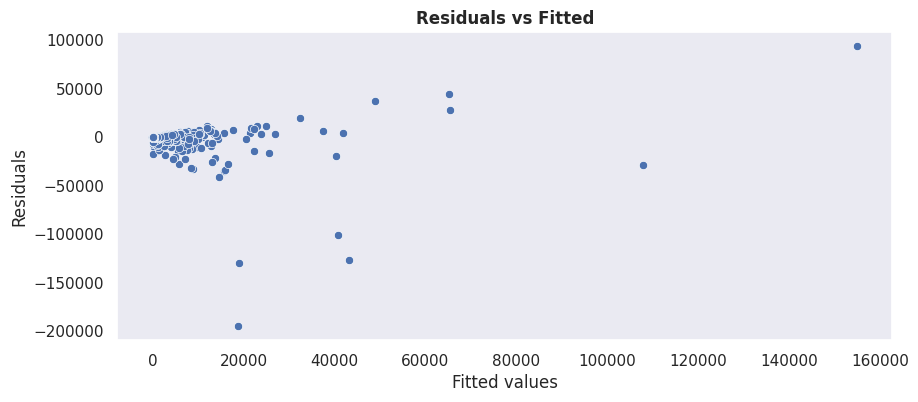

In [36]:
plt.figure(figsize=(10, 4))

# Scatter plot of residuals vs fitted values
sns.scatterplot(x=y_pred, y=resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted', fontweight='bold')

plt.show()

Not the prettiest sight. This tells us that there might be some **influential outliers** in the dataset that need to be extracted prior to fitting the model. Additionally, there appears to be **non-constant variance** among the residuals ($Var(\epsilon) \neq \sigma^2$), violating the homoscedacity assumption of linear regression. While additional transformations can be taken to calm this plot down, this simply means that linear regression might still not be the best fit to model this data. 
# ***PREDICTIONS***

For now, all we can do is be happy with what we've built and move along. Despite violating a lot of major assumptions of linear regression, you'll see that our model actually predicts dislike counts with greater accuracy than us humans, which is a great benchmark for a technique that's been around since the 19th century. 

In [37]:
from copy import deepcopy 

test_sub = deepcopy(test) # To ensure original copy remains unchanged
test_sub = test_sub.drop('dislike_count', axis=1)

In [38]:
y_pred = lr.predict(test_sub)
test['prediction'] = y_pred 

In [39]:
final = test[['dislike_count', 'prediction']]

In [40]:
rmse_new = np.sqrt(np.mean((final['dislike_count']-final['prediction'])**2))
rmse_old = np.sqrt(np.mean((final['dislike_count']-final['dislike_count'].mean())**2))